/tmp/ipykernel_14289/2703484311.py:186: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


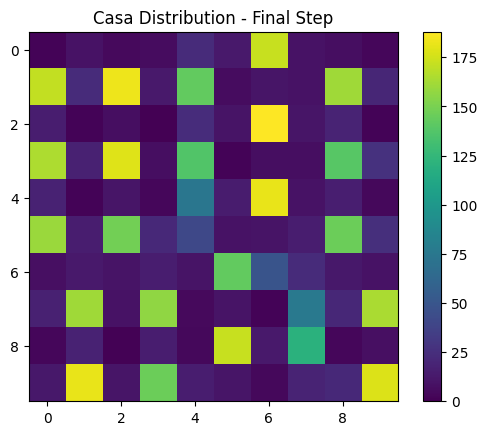

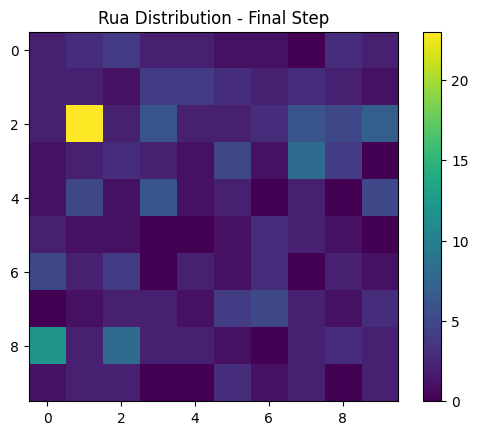

/tmp/ipykernel_14289/2703484311.py:219: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


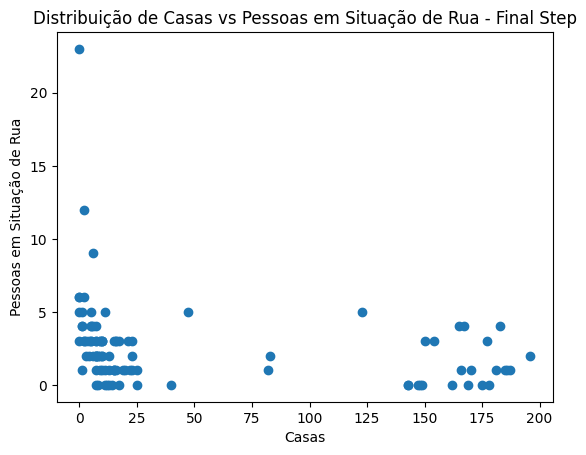

/tmp/ipykernel_14289/2703484311.py:252: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


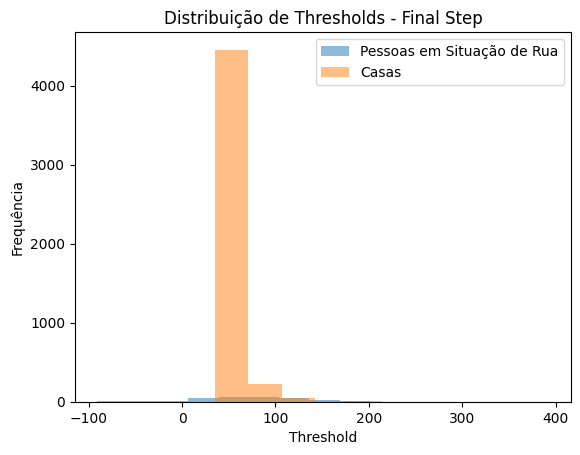

/tmp/ipykernel_14289/2703484311.py:158: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


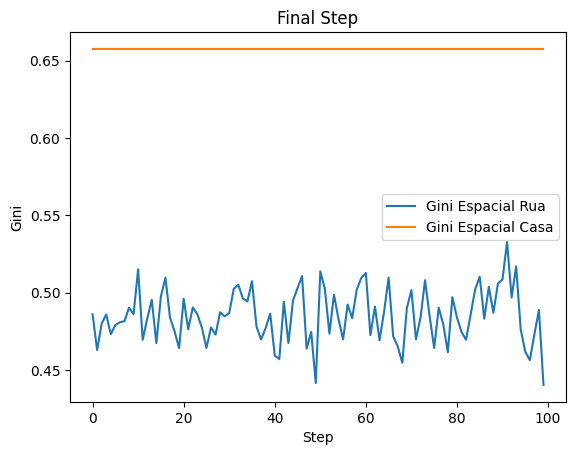

In [2]:
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from scipy.stats import pareto, norm
from random import randint
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import imageio
import os
from PIL import Image, ImageSequence


def compute_mobility(model, tipo_agente):
    mobilidade_agente = [
        agent.move_id
        for agent in model.schedule.agents
        if agent.get_type() == tipo_agente
    ]
    mobility = sum(mobilidade_agente) / len(mobilidade_agente)
    return mobility


def compute_mobility_casa(model):
    return compute_mobility(model, "casa")


def compute_mobility_rua(model):
    return compute_mobility(model, "rua")


def gini_espacial(model, tipo_agente):
    ocup = np.zeros(model.grid.width * model.grid.height)
    for cell, (x, y) in model.grid.coord_iter():
        ocup[x * model.grid.height + y] = len(
            [pessoa for pessoa in cell if pessoa.get_type() == tipo_agente]
        )
    ocup.sort()
    N = model.grid.height * model.grid.width
    B = sum(xi * (N - i) for i, xi in enumerate(ocup)) / (N * sum(ocup))
    return 1 + (1 / N) - 2 * B


def gini_espacial_casa(model):
    return gini_espacial(model, "casa")


def gini_espacial_rua(model):
    return gini_espacial(model, "rua")


class Locacao:
    def __init__(self, width, height, model):
        self.model = model
        self.value_dict = np.zeros((width, height))

    def update_value(self):
        for cell, (x, y) in self.model.grid.coord_iter():
            viz = self.model.grid.get_neighborhood(
                (x, y), moore=True, include_center=True
            )
            pessoas = [
                pessoa
                for cell_v in viz
                for pessoa in self.model.grid.get_cell_list_contents(cell_v)
            ]
            casas = [pessoa for pessoa in pessoas if pessoa.get_type() == "casa"]
            self.value_dict[x, y] = len(casas) / 9

    def get_valor(self, x, y):
        return self.value_dict[x, y]


class Pessoa(Agent):
    def __init__(self, unique_id, model, type_pessoa, thresh):
        super().__init__(unique_id, model)
        self.thresh = thresh
        self.tipo = type_pessoa
        self.move_id = 0

    def move(self):
        new_position = (
            randint(0, self.model.grid.height - 1),
            randint(0, self.model.grid.width - 1),
        )
        self.model.grid.move_agent(self, new_position)

    def get_type(self):
        return self.tipo

    def get_thresh(self):
        return self.thresh

    def step(self):
        if (
            self.tipo == "rua"
            and self.model.grade_valor.get_valor(self.pos[0], self.pos[1]) < self.thresh
        ):
            self.move()
            self.move_id = 1
        elif (
            self.tipo == "casa"
            and self.model.grade_valor.get_valor(self.pos[0], self.pos[1]) > self.thresh
        ):
            self.move()
            self.move_id = 1
        else:
            self.move_id = 0


class MoneyModel(Model):
    def __init__(self, N, width, height, casa_shape, casa_scale, rua_mu, rua_sd):
        super().__init__()
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.grade_valor = Locacao(width, height, self)
        for i in range(self.num_agents):
            if i / self.num_agents > 0.05:
                a = Pessoa(i, self, "casa", pareto.rvs(b=casa_shape) * casa_scale)
            else:
                a = Pessoa(i, self, "rua", norm.rvs(rua_mu, rua_sd))
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={
                "mobilidade_casa": compute_mobility_casa,
                "mobilidade_rua": compute_mobility_rua,
                "gini_espacial_casa": gini_espacial_casa,
                "gini_espacial_rua": gini_espacial_rua,
            }
        )

    def step(self):
        self.grade_valor.update_value()
        self.schedule.step()
        self.datacollector.collect(self)


# Função para salvar imagens temporárias de cada plot
def save_plot_gif(data_rua, data_casa, filename):
    images = []
    for i in range(len(data_rua)):
        plt.plot(data_rua[: i + 1], label="Gini Espacial Rua")
        plt.plot(data_casa[: i + 1], label="Gini Espacial Casa")
        plt.xlabel("Step")
        plt.ylabel("Gini")
        plt.title(f"Step {i+1}")
        plt.legend()
        temp_filename = f"temp_plot_{i}.png"
        plt.savefig(temp_filename)
        plt.close()
        images.append(imageio.imread(temp_filename))
        os.remove(temp_filename)
    plt.plot(data_rua, label="Gini Espacial Rua")
    plt.plot(data_casa, label="Gini Espacial Casa")
    plt.xlabel("Step")
    plt.ylabel("Gini")
    plt.title("Final Step")
    plt.legend()
    plt.show()
    imageio.mimsave(filename, images, fps=2)


def save_agent_distribution_gif(model, filename, agent_type):
    images = []
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for step in range(it):
        model.step()
        for cell, (x, y) in model.grid.coord_iter():
            agent_count = len(
                [pessoa for pessoa in cell if pessoa.get_type() == agent_type]
            )
            agent_counts[x, y] = agent_count
        plt.imshow(agent_counts, interpolation="nearest")
        plt.colorbar()
        plt.title(f"{agent_type.capitalize()} Distribution - Step {step + 1}")
        temp_filename = f"temp_plot_{agent_type}_{step}.png"
        plt.savefig(temp_filename)
        plt.close()
        images.append(imageio.imread(temp_filename))
        os.remove(temp_filename)
    plt.imshow(agent_counts, interpolation="nearest")
    plt.colorbar()
    plt.title(f"{agent_type.capitalize()} Distribution - Final Step")
    plt.show()
    imageio.mimsave(filename, images, fps=2)


def save_scatter_plot_gif(model, filename):
    images = []
    agent_counts_casa = np.zeros((model.grid.width, model.grid.height))
    agent_counts_rua = np.zeros((model.grid.width, model.grid.height))
    for step in range(it):
        model.step()
        for cell, (x, y) in model.grid.coord_iter():
            agent_counts_casa[x, y] = len(
                [pessoa for pessoa in cell if pessoa.get_type() == "casa"]
            )
            agent_counts_rua[x, y] = len(
                [pessoa for pessoa in cell if pessoa.get_type() == "rua"]
            )
        vetor_casa = agent_counts_casa.flatten()
        vetor_rua = agent_counts_rua.flatten()
        plt.scatter(vetor_casa, vetor_rua)
        plt.xlabel("Casas")
        plt.ylabel("Pessoas em Situação de Rua")
        plt.title(
            f"Distribuição de Casas vs Pessoas em Situação de Rua - Step {step + 1}"
        )
        temp_filename = f"temp_scatter_plot_{step}.png"
        plt.savefig(temp_filename)
        plt.close()
        images.append(imageio.imread(temp_filename))
        os.remove(temp_filename)
    plt.scatter(vetor_casa, vetor_rua)
    plt.xlabel("Casas")
    plt.ylabel("Pessoas em Situação de Rua")
    plt.title("Distribuição de Casas vs Pessoas em Situação de Rua - Final Step")
    plt.show()
    imageio.mimsave(filename, images, fps=2)


def save_histogram_gif(model, filename):
    images = []
    for step in range(it):
        model.step()
        thresh_casa = [
            agente.get_thresh()
            for agente in model.schedule.agents
            if agente.get_type() == "casa"
        ]
        thresh_rua = [
            agente.get_thresh()
            for agente in model.schedule.agents
            if agente.get_type() == "rua"
        ]
        plt.hist(thresh_rua, alpha=0.5, label="Pessoas em Situação de Rua")
        plt.hist(thresh_casa, alpha=0.5, label="Casas")
        plt.xlabel("Threshold")
        plt.ylabel("Frequência")
        plt.title(f"Distribuição de Thresholds - Step {step + 1}")
        plt.legend()
        temp_filename = f"temp_histogram_{step}.png"
        plt.savefig(temp_filename)
        plt.close()
        images.append(imageio.imread(temp_filename))
        os.remove(temp_filename)
    plt.hist(thresh_rua, alpha=0.5, label="Pessoas em Situação de Rua")
    plt.hist(thresh_casa, alpha=0.5, label="Casas")
    plt.xlabel("Threshold")
    plt.ylabel("Frequência")
    plt.title("Distribuição de Thresholds - Final Step")
    plt.legend()
    plt.show()
    imageio.mimsave(filename, images, fps=2)


def combine_gifs(gif_files, output_file, columns=3):
    # Load all gifs
    gifs = [Image.open(gif) for gif in gif_files]

    # Determine the size of each frame
    width, height = gifs[0].size

    # Calculate the size of the final image
    rows = (len(gif_files) + columns - 1) // columns
    total_width = columns * width
    total_height = rows * height

    # Create a list to hold all frames of the new combined gif
    frames = []

    # Iterate through frames of the first gif (assuming all gifs have the same number of frames)
    for frame_number, frame in enumerate(ImageSequence.Iterator(gifs[0])):
        # Create a new blank image for the combined frame
        new_frame = Image.new("RGB", (total_width, total_height))

        # Paste each gif's corresponding frame into the combined frame
        for idx, gif in enumerate(gif_files):
            x_offset = (idx % columns) * width
            y_offset = (idx // columns) * height
            frame = ImageSequence.Iterator(gifs[idx])[frame_number]
            new_frame.paste(frame, (x_offset, y_offset))

        # Append the combined frame to the list of frames
        frames.append(new_frame)

    # Save the combined frames as a new gif
    frames[0].save(
        output_file, save_all=True, append_images=frames[1:], duration=100, loop=0
    )


def explore_parameters():
    # Parâmetros para simulação
    dens_mu = np.linspace(40, 60, 3)  # Aumentar a densidade
    casa_shape = np.linspace(1.1, 4, 3)  # Aumentar a forma da Pareto
    casa_scale = np.linspace(10, 100, 3)  # Aumentar a escala da Pareto
    rua_mu = np.linspace(40, 80, 3)  # Variar mais a média da Normal
    rua_sd = np.linspace(1, 10, 3)  # Aumentar a variação do desvio padrão
    it = 100  # Aumentar o número de iterações
    first = True

    # Adicionando barra de progresso
    total_simulations = (
        len(dens_mu) * len(casa_shape) * len(casa_scale) * len(rua_mu) * len(rua_sd)
    )
    with tqdm(total=total_simulations) as pbar:
        for dens in dens_mu:
            for csh in casa_shape:
                for css in casa_scale:
                    for rmu in rua_mu:
                        for rsd in rua_sd:
                            teste = MoneyModel(
                                int(10 * 10 * dens), 10, 10, csh, css, rmu, rsd
                            )
                            for i in range(it):
                                teste.step()
                            dados_simulacao_atual = (
                                teste.datacollector.get_model_vars_dataframe().iloc[-1:]
                            )
                            dados_simulacao_atual["dens_mu"] = dens
                            dados_simulacao_atual["casa_shape"] = csh
                            dados_simulacao_atual["casa_scale"] = css
                            dados_simulacao_atual["rua_mu"] = rmu
                            dados_simulacao_atual["rua_sd"] = rsd
                            if first:
                                dados_simulacao = dados_simulacao_atual
                                first = False
                            else:
                                dados_simulacao = pd.concat(
                                    [dados_simulacao, dados_simulacao_atual]
                                )
                            pbar.update(1)
    return dados_simulacao


# # Parâmetros
# num_agents = int(10 * 10 * 50)  # Número de agentes # int(10 * 10 * 50)
# grid_width = 10  # Largura do grid # 10
# grid_height = 10  # Altura do grid # 10
# casa_shape = 3  # Forma da distribuição Pareto para agentes "casa" # 3
# casa_scale = 42  # Escala da distribuição Pareto para agentes "casa" # 42
# rua_mu = 71  # Média da distribuição Normal para agentes "rua" # 71
# rua_sd = 100  # Desvio padrão da distribuição Normal para agentes "rua" # 57
# it = 100  # Aumentar o número de iterações # 100
# first = True # True

# Parâmetros
num_agents = int(10 * 10 * 50)  # Número de agentes
grid_width = 10  # Largura do grid
grid_height = 10  # Altura do grid
casa_shape = 4  # Forma da distribuição Pareto para agentes "casa"
casa_scale = 35  # Escala da distribuição Pareto para agentes "casa"
rua_mu = 71  # Média da distribuição Normal para agentes "rua"
rua_sd = 57  # Desvio padrão da distribuição Normal para agentes "rua"
it = 100  # Aumentar o número de iterações
first = True

# Teste de emergência com parâmetros específicos # tivemos emergencia com: (int(10*10*50), 10, 10, 3, 42, 3, 57)
teste = MoneyModel(
    N=num_agents,
    width=grid_width,
    height=grid_height,
    casa_shape=casa_shape,
    casa_scale=casa_scale,
    rua_mu=rua_mu,
    rua_sd=rua_sd,
)

# Criação do GIF para distribuição de agentes tipo "casa"
save_agent_distribution_gif(teste, "distribuicao_casa.gif", "casa")

# Criação do GIF para distribuição de agentes tipo "rua"
save_agent_distribution_gif(teste, "distribuicao_rua.gif", "rua")

# Criação do GIF para scatter plot entre casas e pessoas em situação de rua
save_scatter_plot_gif(teste, "scatter_plot.gif")

# Criação do GIF para histograma dos thresholds dos agentes
save_histogram_gif(teste, "histogram.gif")

# Criação do GIF para a mobilidade dos agentes
mobilidade_rua_data = []
mobilidade_casa_data = []
for i in range(it):
    teste.step()
    mobilidade_rua_data.append(
        teste.datacollector.get_model_vars_dataframe()["gini_espacial_rua"].iloc[-1]
    )
    mobilidade_casa_data.append(
        teste.datacollector.get_model_vars_dataframe()["gini_espacial_casa"].iloc[-1]
    )

save_plot_gif(mobilidade_rua_data, mobilidade_casa_data, "mobilidade.gif")

# List of gif files to combine
gif_files = [
    "distribuicao_casa.gif",
    "distribuicao_rua.gif",
    "scatter_plot.gif",
    "histogram.gif",
    "mobilidade.gif",
]

# Output file name
output_file = "combined.gif"

# Combine the gifs
combine_gifs(gif_files, output_file)